In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import butter, lfilter
from sklearn.cross_decomposition import CCA
import os
import operator

In [2]:
## OZ - 16
## O1 - 8
## O2 - 11
## Cz - 3
## PO3 - 13
## PO4 - 14
## POz - 15

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
    
def get_corr(data_eeg, model_signals):
    cca = CCA(n_components=1)
    len_result = model_signals.shape[0]
    results = dict(zip(target_freqs,np.zeros(len_result)))

    for index in np.arange(len_result):
        #model_signal_temp = model_signals[index].reshape(-1,1)
        cca.fit(data_eeg.T, model_signals[index,:,:].T)
        O1_a,O1_b = cca.transform(data_eeg.T, model_signals[index,:,:].T)
        results[target_freqs[index]] = np.corrcoef(O1_a[:,0],O1_b[:,0])[0,1]
    
    return results

def getReferenceSignals(length, target_freq, samplingRate):
	# generate sinusoidal reference templates for CCA for the first and second harmonics
	reference_signals = []
	t = np.arange(0, (length/(samplingRate)), step=1.0/(samplingRate))
	#First harmonics/Fundamental freqeuncy
	reference_signals.append(np.sin(np.pi*2*target_freq*t))
	reference_signals.append(np.cos(np.pi*2*target_freq*t))
	#Second harmonics
	reference_signals.append(np.sin(np.pi*4*target_freq*t))
	reference_signals.append(np.cos(np.pi*4*target_freq*t))
	reference_signals = np.array(reference_signals)
	return reference_signals

In [4]:
cwd = os.getcwd()
data_path = cwd + '\\' + 'paolo_db\\'

In [5]:
x = np.load(data_path+"gary_15.npy")

In [6]:
#fundamental = 10

xs = np.squeeze(x)
xs = xs.T
ref = xs[2][30:]
xs_O1 = xs[7][30:] - ref 
xs_O2 = xs[10][30:] - ref
xs_Oz = xs[15][30:] - ref
xs_POz = xs[14][30:] - ref
xs_PO4 = xs[13][30:] - ref
xs_PO3 = xs[12][30:] - ref

xs_O1_mean = xs_O1 - np.mean(xs_O1)
xs_O2_mean = xs_O2 - np.mean(xs_O2)
xs_Oz_mean = xs_Oz - np.mean(xs_Oz)
xs_POz_mean = xs_POz - np.mean(xs_POz)
xs_PO3_mean = xs_PO3 - np.mean(xs_PO3)
xs_PO4_mean = xs_PO4 - np.mean(xs_PO4)

xs_O1_norm = (xs_O1_mean-np.min(xs_O1_mean))/(np.max(xs_O1_mean)-np.min(xs_O1_mean))
xs_O2_norm = (xs_O2_mean-np.min(xs_O2_mean))/(np.max(xs_O2_mean)-np.min(xs_O2_mean))
xs_Oz_norm = (xs_Oz_mean-np.min(xs_Oz_mean))/(np.max(xs_Oz_mean)-np.min(xs_Oz_mean))
xs_POz_norm = (xs_POz_mean-np.min(xs_POz_mean))/(np.max(xs_POz_mean)-np.min(xs_POz_mean))
xs_PO3_norm = (xs_PO3_mean-np.min(xs_PO3_mean))/(np.max(xs_PO3_mean)-np.min(xs_PO3_mean))
xs_PO4_norm = (xs_PO4_mean-np.min(xs_PO4_mean))/(np.max(xs_PO4_mean)-np.min(xs_PO4_mean))

xs_Oz_filtered = bandpass_filter(xs_Oz_norm,5,32,256,9)
xs_POz_filtered = bandpass_filter(xs_POz_norm,5,32,256,9)
xs_PO3_filtered = bandpass_filter(xs_PO3_norm,5,32,256,9)
xs_PO4_filtered = bandpass_filter(xs_PO4_norm,5,32,256,9)
xs_O1_filtered = bandpass_filter(xs_O1_norm,5,32,256,9)
xs_O2_filtered = bandpass_filter(xs_O2_norm,5,32,256,9)

data_eeg = np.array([xs_Oz_filtered, xs_O2_filtered, xs_PO3_filtered, xs_PO4_filtered, xs_POz_filtered])


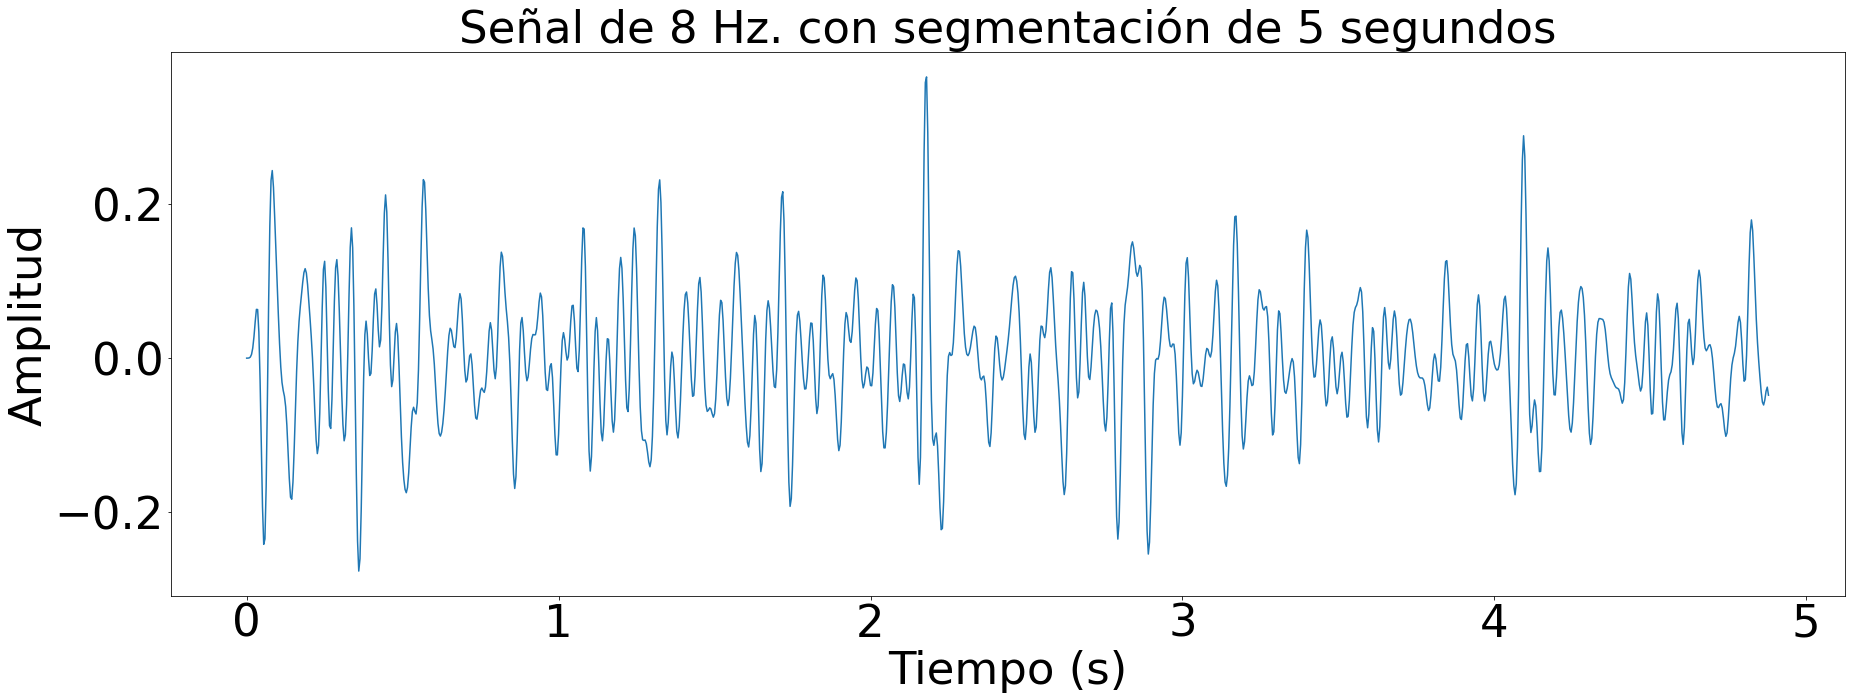

In [8]:
sr = 256
t = np.arange(0, (len(xs_Oz_norm)/(256)), step=1.0/(256))
plt.figure(figsize=(30,10))
plt.plot(t, xs_Oz_filtered)
plt.tick_params(axis='x', labelsize = 45)
plt.tick_params(axis='y', labelsize = 45)
plt.xlabel("Tiempo (s)", fontsize=45)
plt.ylabel("Amplitud", fontsize=45)
plt.title('Señal de 8 Hz. con segmentación de 5 segundos', fontsize = 45)

plt.show()

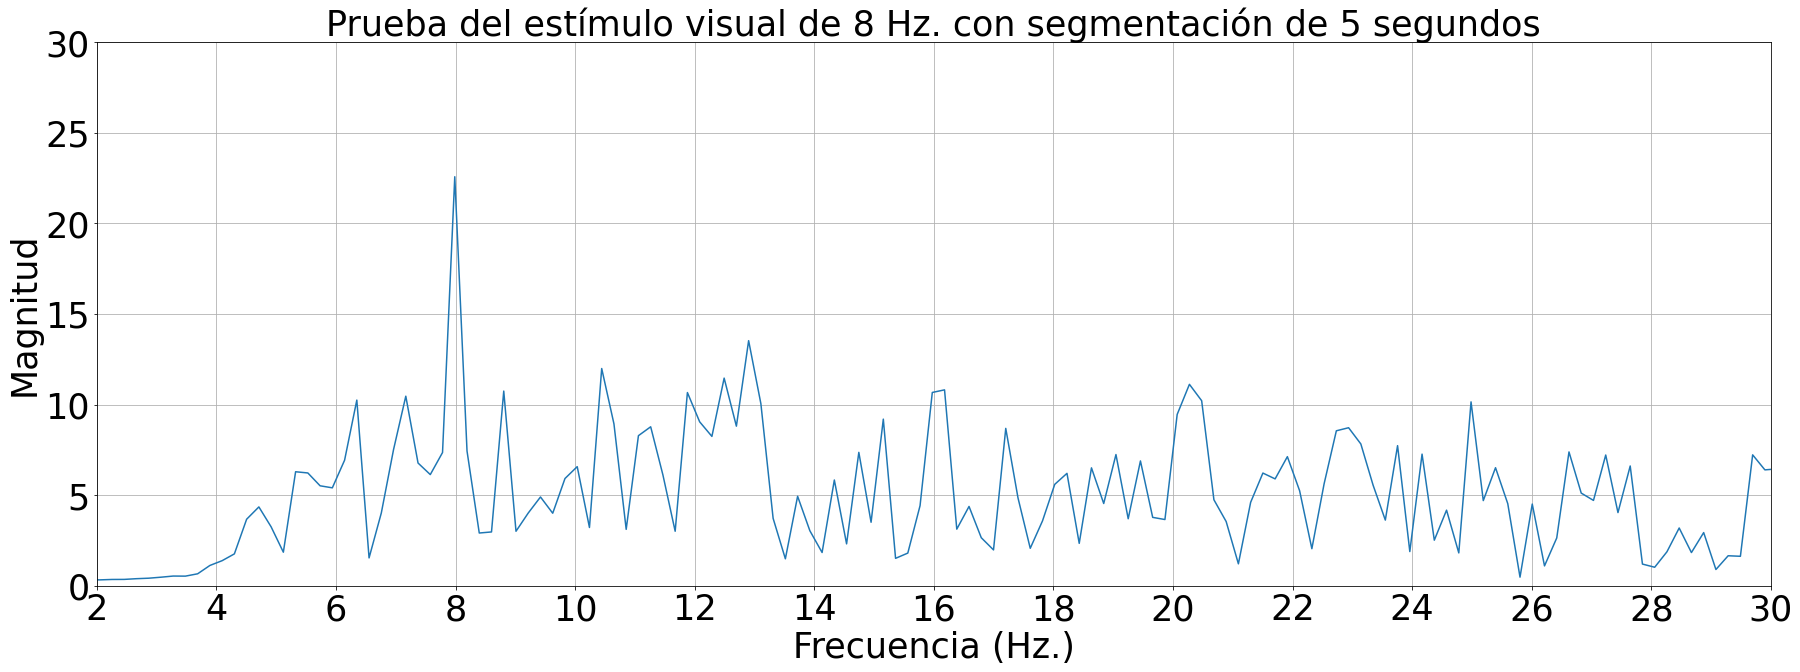

In [9]:
x_fft = fft(xs_Oz_filtered)
N = len(x_fft)
n = np.arange(N)
sr = 256
T = N/sr
freq = n/T 
n_oneside = N//2
f_oneside = freq[:n_oneside]
plt.figure(figsize=(30,10))
plt.plot(f_oneside, np.abs(x_fft[:n_oneside]))
plt.xticks(np.arange(min(f_oneside), max(f_oneside)+1, 2.0))
plt.tick_params(axis='x', labelsize = 35)
plt.tick_params(axis='y', labelsize = 35)
plt.xlabel("Frecuencia (Hz.)", fontsize=35)
plt.ylabel("Magnitud", fontsize=35)
plt.title('Prueba del estímulo visual de 8 Hz. con segmentación de 5 segundos', fontsize = 35)
plt.xlim([2,30])
plt.ylim([0,30])
plt.grid()
plt.show()

In [133]:
target_freqs = [6,10,8,15]
sr = 256
freq1 = getReferenceSignals(len(xs_POz_filtered), target_freqs[0],sr)
freq2 = getReferenceSignals(len(xs_POz_filtered), target_freqs[1],sr)
freq3 = getReferenceSignals(len(xs_POz_filtered), target_freqs[2],sr)
freq4 = getReferenceSignals(len(xs_POz_filtered), target_freqs[3],sr)
freqs = np.array([freq1,freq2,freq3,freq4])

In [134]:
res = get_corr(data_eeg, freqs)
res

{6: 0.18051282953872566,
 10: 0.18251271212346065,
 8: 0.5654338978155853,
 15: 0.2071116247344661}

In [40]:
max(res.items(), key=operator.itemgetter(1))[0]

15